In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, MultiHeadAttention, Flatten, Concatenate, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from transformers import AutoTokenizer, AutoModel
import torch

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, LayerNormalization, GlobalAveragePooling1D, Conv1D

In [2]:
statistics = pd.read_csv("istatistikler.csv")

news = pd.read_csv("haberler.csv")

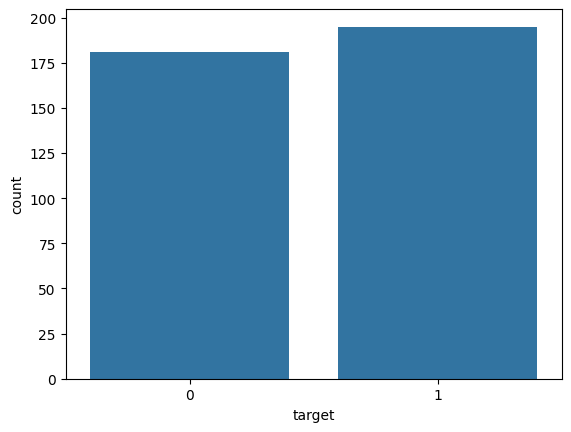

In [3]:
# target
sns.countplot(data=statistics, x="target")
plt.show()

In [4]:
news.head()

,title,text,clean_text,date,year,month,day
0,Savunmada Gelişenler ve yerinde sayanlar,Lefteris Moutis/moutis@eurohoops.net\nEurohoop...,lefteris eurohoops olarak eurolig deki takımla...,2015-03-02 13:56:00,2015,3,2
1,Galatasaray Fenerbahçe’ye Teslim Olmuyor,By Eurohoops team/info@eurohoops.netGalatasara...,galatasaraydüşüyor ama asla teslim olmuyor. si...,2015-05-24 17:10:00,2015,5,24
2,Avrupa’da Maç Programı ve Yayın Akışı,By Eurohoops Team/info@eurohoops.net\nEuroleag...,euroleague ve eurocup ta mücadele edecek takım...,2015-10-26 12:46:00,2015,10,26
3,“Atılan Üçlükler Fenerbahçe’yi Zor Durumda Bır...,"Torku Konyaspor koçu Aziz Bekir, maç sonu yapt...","torku konyaspor koçu aziz bekir, maç sonu yapt...",2015-10-26 21:06:00,2015,10,26
4,Fenerbahçe Tarihinde İlk!,By Eurohoops Team/info@eurohoops.net\nFenerbah...,"fenerbahçe, torku konyaspor maçında tarihinde ...",2015-10-27 10:34:00,2015,10,27


In [5]:
statistics.head()

,Opposing Team,IsHome,Points,Performance Index Rating,Two-point %,Three-point %,Free-throw %,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Turnovers,Day,Month,Year,Date,target
0,CSKA Moscow,1,81.0,76.0,42.9,38.5,62.5,13.0,30.0,43.0,20.0,5.0,5.0,19.0,2,1,2015,2015-01-02,0
1,Nizhny Novgorod,0,78.0,80.0,56.9,33.3,35.7,12.0,21.0,33.0,8.0,6.0,3.0,4.0,9,1,2015,2015-01-09,0
2,Olympiacos Piraeus,1,68.0,65.0,51.4,39.1,45.5,7.0,19.0,26.0,14.0,5.0,6.0,11.0,16,1,2015,2015-01-16,0
3,EA7 Emporio Armani Milan,0,82.0,99.0,63.0,21.1,85.7,13.0,20.0,33.0,18.0,9.0,3.0,9.0,22,1,2015,2015-01-22,1
4,Unicaja Malaga,0,68.0,81.0,57.9,27.8,69.2,8.0,30.0,38.0,16.0,9.0,3.0,15.0,30,1,2015,2015-01-30,0


### Data Alignment

In [6]:
statistics['Date'] = pd.to_datetime(statistics['Date'])
news['date'] = pd.to_datetime(news['date'])

In [7]:
def get_related_news(game_date, news_df, window_days=3):
    # Maçtan önceki pencereyi belirle
    start_date = game_date - timedelta(days=window_days)
    end_date = game_date - timedelta(days=1) # Maç gününü dahil etmiyoruz (garanti olsun)

    # O tarihler arasındaki haberleri filtrele
    mask = (news_df['date'] >= start_date) & (news_df['date'] <= end_date)
    related_news = news_df.loc[mask, 'clean_text'].tolist()

    # Haberleri tek bir metin olarak birleştir
    if len(related_news) > 0:
        return " ".join(related_news)
    else:
        return "no_news_available"

# Yeni sütunu oluştur
statistics['combined_news'] = statistics['Date'].apply(lambda x: get_related_news(x, news))

In [8]:
with pd.option_context('display.max_colwidth', None):
    display(statistics.iloc[100])

,100
Opposing Team,Panathinaikos Superfoods Athens
IsHome,1
Points,67.0
Performance Index Rating,77.0
Two-point %,48.8
Three-point %,26.3
Free-throw %,71.4
Offensive rebounds,12.0
Defensive rebounds,26.0
Total rebounds,38.0


In [9]:
df = statistics.copy()
df.head()

,Opposing Team,IsHome,Points,Performance Index Rating,Two-point %,Three-point %,Free-throw %,Offensive rebounds,Defensive rebounds,Total rebounds,Assists,Steals,Blocks,Turnovers,Day,Month,Year,Date,target,combined_news
0,CSKA Moscow,1,81.0,76.0,42.9,38.5,62.5,13.0,30.0,43.0,20.0,5.0,5.0,19.0,2,1,2015,2015-01-02,0,no_news_available
1,Nizhny Novgorod,0,78.0,80.0,56.9,33.3,35.7,12.0,21.0,33.0,8.0,6.0,3.0,4.0,9,1,2015,2015-01-09,0,no_news_available
2,Olympiacos Piraeus,1,68.0,65.0,51.4,39.1,45.5,7.0,19.0,26.0,14.0,5.0,6.0,11.0,16,1,2015,2015-01-16,0,no_news_available
3,EA7 Emporio Armani Milan,0,82.0,99.0,63.0,21.1,85.7,13.0,20.0,33.0,18.0,9.0,3.0,9.0,22,1,2015,2015-01-22,1,no_news_available
4,Unicaja Malaga,0,68.0,81.0,57.9,27.8,69.2,8.0,30.0,38.0,16.0,9.0,3.0,15.0,30,1,2015,2015-01-30,0,no_news_available


## MLP (statistics) + BERTurk (news)


In [10]:
X = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"])
y = df["target"]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Fold 1 tamamlandı -> Acc: 0.8684 | F1: 0.8684 | AUC: 0.9480
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
Fold 2 tamamlandı -> Acc: 0.9067 | F1: 0.9114 | AUC: 0.9637


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Fold 3 tamamlandı -> Acc: 0.9333 | F1: 0.9367 | AUC: 0.9893
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Fold 4 tamamlandı -> Acc: 0.9600 | F1: 0.9610 | AUC: 0.9765
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Fold 5 tamamlandı -> Acc: 0.9200 | F1: 0.9211 | AUC: 0.9679

NİHAİ SONUÇLAR (Mean ± Std)
Accuracy:    0.9177 ± 0.0303
F1-Score:    0.9197 ± 0.0307
ROC-AUC:     0.9691 ± 0.0137
Precision:   0.9273 ± 0.0300
Recall:      0.9128 ± 0.0384
Sensitivity: 0.9128 ± 0.0384
Specificity: 0.9228 ± 0.0318

GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.91      0.92      0.92       181
    PIR > 90       0.93      0.91      0.92       195

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376



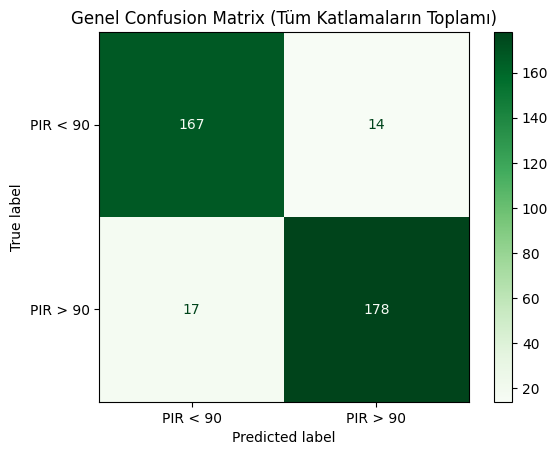

In [11]:
# Metrikleri ve tüm tahminleri tutmak için listeler
fold_accuracies, fold_f1s, fold_precisions, fold_recalls = [], [], [], []
fold_sensitivities, fold_specificities, fold_aucs = [], [], []

# Tüm fold'lardaki gerçek değerleri ve tahminleri toplamak için
all_y_true = []
all_y_pred = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_cv)
    X_val_scaled = scaler.transform(X_val_cv)

    # MODEL MİMARİSİ
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(30, activation="relu"),
        Dense(15, activation="relu"),
        Dense(15, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    model.fit(X_train_scaled, y_train_cv, epochs=50, batch_size=32, verbose=0)

    # TAHMİN (Olasılık ve Sınıf)
    y_probs = model.predict(X_val_scaled)
    y_pred = (y_probs > 0.5).astype("int32")

    # Genel Rapor İçin Tahminleri Sakla
    all_y_true.extend(y_val_cv)
    all_y_pred.extend(y_pred.flatten())

    # METRİKLER HESAPLAMA (Fold Bazlı)
    acc = accuracy_score(y_val_cv, y_pred)
    f1 = f1_score(y_val_cv, y_pred)
    auc = roc_auc_score(y_val_cv, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val_cv, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Listelere ekleme
    fold_accuracies.append(acc)
    fold_f1s.append(f1)
    fold_aucs.append(auc)
    fold_precisions.append(precision_score(y_val_cv, y_pred))
    fold_recalls.append(recall_score(y_val_cv, y_pred))
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# --- TÜM FOLD'LAR BİTTİKTEN SONRA ---

print("\n" + "="*40)
print("NİHAİ SONUÇLAR (Mean ± Std)")
print(f"Accuracy:    {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"F1-Score:    {np.mean(fold_f1s):.4f} ± {np.std(fold_f1s):.4f}")
print(f"ROC-AUC:     {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")
print(f"Precision:   {np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")
print(f"Recall:      {np.mean(fold_recalls):.4f} ± {np.std(fold_recalls):.4f}")
print(f"Sensitivity: {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}")
print(f"Specificity: {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}")
print("="*40)

# 1. Genel Classification Report (Tüm veriler için)
print("\nGENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true, all_y_pred, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PIR < 90', 'PIR > 90'])
disp.plot(cmap=plt.cm.Greens)
plt.title("Genel Confusion Matrix (Tüm Katlamaların Toplamı)")
plt.show()

In [12]:
# 1. Model ve Tokenizer Yükleme (BERTurk)
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [13]:
def get_bert_embeddings(text_list):
    # BERT'in 512 token sınırı vardır, metinleri buna göre kırpıyoruz
    inputs = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # [CLS] token'ının çıktısını alıyoruz (Metnin tamamını temsil eden 768-D vektör)
    # Rehberdeki text_feat (768) buna karşılık gelir [cite: 10]
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# 2. Veri Setindeki Metinleri Vektöre Dönüştürme
print("Metinler vektörleştiriliyor (Bu işlem zaman alabilir)...")

text_features = []
for i in range(0, len(statistics)):
    text = statistics['combined_news'].iloc[i]
    emb = get_bert_embeddings([text])
    text_features.append(emb[0])

# Sonucu ana tabloya eklemek üzere numpy array yapıyoruz
X_text_features = np.array(text_features)
print(f"Metin özellik matrisi hazır: {X_text_features.shape}")

Metinler vektörleştiriliyor (Bu işlem zaman alabilir)...
Metin özellik matrisi hazır: (376, 768)


BERTurk Single-Modality Testi Başlıyor...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Fold 1 tamamlandı -> Acc: 0.5395 | F1: 0.4928 | AUC: 0.5357
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 2 tamamlandı -> Acc: 0.4133 | F1: 0.5217 | AUC: 0.3839
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Fold 3 tamamlandı -> Acc: 0.5200 | F1: 0.4857 | AUC: 0.5203
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Fold 4 tamamlandı -> Acc: 0.4400 | F1: 0.4324 | AUC: 0.4448
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Fold 5 tamamlandı -> Acc: 0.4933 | F1: 0.4062 | AUC: 0.4651

TEXT-ONLY (BERTurk) NİHAİ SONUÇLAR (Mean ± Std)
Accuracy:    0.4812 ± 0.0476
F1-Score:    0.4678 ± 0.0422
ROC-AUC:     0.4700 ± 0.0546
Precision:   0.5090 ± 0.0466
Recall:      0.4462 ± 0.0926
Sensitivity: 0.4462 ± 0.0926
Specificity: 0.5186 ± 0.1759

BERTurk GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.47      0.52      0.49       181
    PIR > 90       0.50      0.45      0.47       195

    accuracy

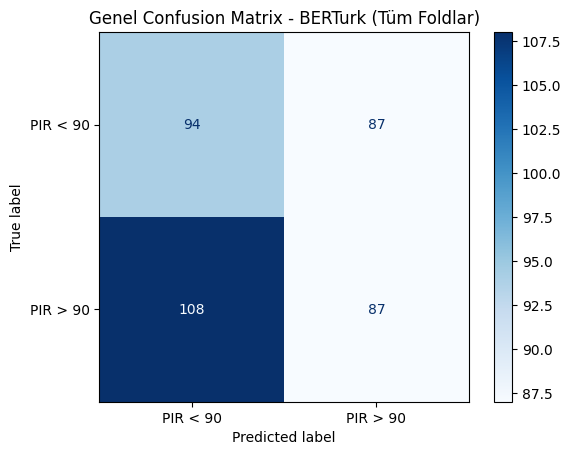

In [14]:
# Metrik listelerini ve tüm tahminleri tutmak için listeler
text_acc, text_f1, text_prec, text_rec = [], [], [], []
text_sens, text_spec, text_aucs = [], [], []

all_y_true_text = []
all_y_pred_text = []

print("BERTurk Single-Modality Testi Başlıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_features, y), 1):
    # Veriyi böl
    X_t_train, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_t_train, y_t_val = y[train_idx], y[val_idx]

    # Model: BERT vektörlerini sınıflayacak hiyerarşik MLP
    model_text = Sequential([
        Input(shape=(768,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model_text.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model_text.fit(X_t_train, y_t_train, epochs=20, batch_size=16, verbose=0)

    # Tahmin (Olasılık ve Sınıf)
    y_probs = model_text.predict(X_t_val)
    y_pred = (y_probs > 0.5).astype(int)

    # Genel Raporlama İçin Sakla
    all_y_true_text.extend(y_t_val)
    all_y_pred_text.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_t_val, y_pred)
    f1 = f1_score(y_t_val, y_pred)
    auc = roc_auc_score(y_t_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_t_val, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Listelere ekle
    text_acc.append(acc)
    text_f1.append(f1)
    text_prec.append(precision_score(y_t_val, y_pred))
    text_rec.append(recall_score(y_t_val, y_pred))
    text_sens.append(sensitivity)
    text_spec.append(specificity)
    text_aucs.append(auc)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")



print("\n" + "="*40)
print("TEXT-ONLY (BERTurk) NİHAİ SONUÇLAR (Mean ± Std)")
print(f"Accuracy:    {np.mean(text_acc):.4f} ± {np.std(text_acc):.4f}")
print(f"F1-Score:    {np.mean(text_f1):.4f} ± {np.std(text_f1):.4f}")
print(f"ROC-AUC:     {np.mean(text_aucs):.4f} ± {np.std(text_aucs):.4f}")
print(f"Precision:   {np.mean(text_prec):.4f} ± {np.std(text_prec):.4f}")
print(f"Recall:      {np.mean(text_rec):.4f} ± {np.std(text_rec):.4f}")
print(f"Sensitivity: {np.mean(text_sens):.4f} ± {np.std(text_sens):.4f}")
print(f"Specificity: {np.mean(text_spec):.4f} ± {np.std(text_spec):.4f}")
print("="*40)

# 1. Genel Classification Report
print("\nBERTurk GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_text, all_y_pred_text, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_text = confusion_matrix(all_y_true_text, all_y_pred_text)
disp_text = ConfusionMatrixDisplay(confusion_matrix=cm_text, display_labels=['PIR < 90', 'PIR > 90'])
disp_text.plot(cmap=plt.cm.Blues)
plt.title("Genel Confusion Matrix - BERTurk (Tüm Foldlar)")
plt.show()

### Early Fusion

Early Fusion Başlatılıyor... Veri boyutu: (376, 780)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Fold 1 tamamlandı -> Acc: 0.8421 | F1: 0.8605 | AUC: 0.9404
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Fold 2 tamamlandı -> Acc: 0.8000 | F1: 0.7887 | AUC: 0.8917
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 3 tamamlandı -> Acc: 0.8400 | F1: 0.8537 | AUC: 0.9373
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Fold 4 tamamlandı -> Acc: 0.9067 | F1: 0.9067 | AUC: 0.9786
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 5 tamamlandı -> Acc: 0.8267 | F1: 0.8312 | AUC: 0.8910

EARLY FUSION FINAL RESULTS (Mean ± Std)
ACC       : 0.8431 ± 0.0352
F1        : 0.8481 ± 0.0385
PREC      : 0.8525 ± 0.0544
REC       : 0.8513 ± 0.0784
SENS      : 0.8513 ± 0.0784
SPEC      : 0.8348 ± 0.0765
AUC       : 0.9278 ± 0.0331

EARLY FUSION GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.84      0.83      0.84       181
    PIR > 90       0.85      0.85      0.85       195

    accuracy 

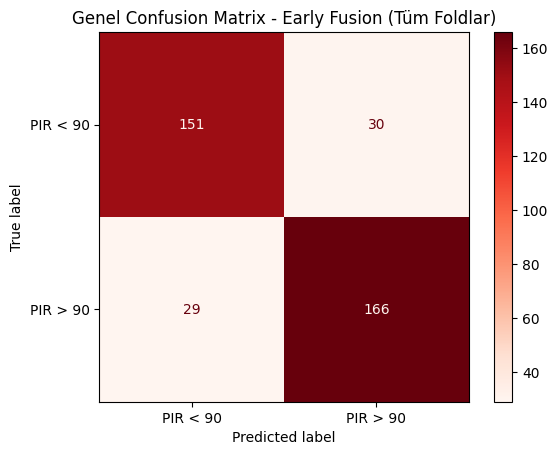

In [24]:
# 1. Ham Verileri Hazırla
X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
# X_text_features (376, 768) boyutunda olduğu varsayılmıştır
X_combined_raw = np.concatenate([X_stats_raw, X_text_features], axis=1)
y = df["target"].values

# Metrik listeleri ve genel tahmin havuzu
ef_metrics = {
    'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []
}
all_y_true_ef = []
all_y_pred_ef = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Early Fusion Başlatılıyor... Veri boyutu: {X_combined_raw.shape}")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_combined_raw, y), 1):
    X_train, X_val = X_combined_raw[train_idx], X_combined_raw[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Sadece İstatistiksel Özellikleri (İlk 12 sütun) Ölçeklendir
    scaler = StandardScaler()
    X_train[:, :12] = scaler.fit_transform(X_train[:, :12])
    X_val[:, :12] = scaler.transform(X_val[:, :12])

    # Model Mimarisi (128 -> 64 -> 1)
    model = Sequential([
        Input(shape=(X_combined_raw.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

    # Tahmin (Olasılık ve Sınıf)
    y_probs = model.predict(X_val)
    y_pred = (y_probs > 0.5).astype("int32")

    # Genel Raporlama İçin Kaydet
    all_y_true_ef.extend(y_val)
    all_y_pred_ef.extend(y_pred.flatten())

    # Metriklerin Hesaplanması
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Listelere ekle
    ef_metrics['acc'].append(acc); ef_metrics['f1'].append(f1)
    ef_metrics['prec'].append(precision_score(y_val, y_pred))
    ef_metrics['rec'].append(recall_score(y_val, y_pred))
    ef_metrics['sens'].append(sens); ef_metrics['spec'].append(spec)
    ef_metrics['auc'].append(auc)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


print("\n" + "="*45)
print("EARLY FUSION FINAL RESULTS (Mean ± Std)")
for key, values in ef_metrics.items():
    print(f"{key.upper():10}: {np.mean(values):.4f} ± {np.std(values):.4f}")
print("="*45)

# 1. Genel Classification Report
print("\nEARLY FUSION GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_ef, all_y_pred_ef, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_ef = confusion_matrix(all_y_true_ef, all_y_pred_ef)
disp_ef = ConfusionMatrixDisplay(confusion_matrix=cm_ef, display_labels=['PIR < 90', 'PIR > 90'])
disp_ef.plot(cmap=plt.cm.Reds)
plt.title("Genel Confusion Matrix - Early Fusion (Tüm Foldlar)")
plt.show()

### Intermediate Fusion

Intermediate Fusion (Cross-Attention) Başlatılıyor...

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
Fold 1 tamamlandı -> Acc: 0.8289 | F1: 0.8267 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 775ms/step
Fold 2 tamamlandı -> Acc: 0.8533 | F1: 0.8533 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Fold 3 tamamlandı -> Acc: 0.9333 | F1: 0.9367 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Fold 4 tamamlandı -> Acc: 0.9333 | F1: 0.9383 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
Fold 5 tamamlandı -> Acc: 0.9067 | F1: 0.9136 | AUC: 0.8910

INTERMEDIATE FUSION FINAL RESULTS (Mean ± Std)
ACC       : 0.8911 ± 0.0427
F1        : 0.8937 ± 0.0455
PREC      : 0.8921 ± 0.0216
REC       : 0.8974 ± 0.0743
SENS      : 0.8974 ± 0.0743
SPEC      : 0.8841 ± 0.0200
AUC       : 0.9614 ± 0.0247

INTERMEDIATE FUSION GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.89      0.88      0.89       181
    PIR > 90       0.89      0.90      0.90    

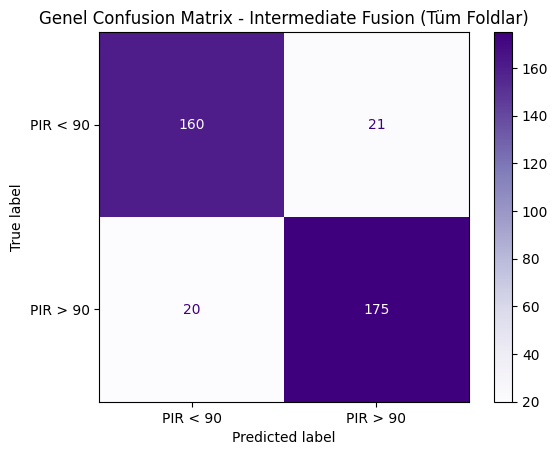

In [25]:
def create_intermediate_model(stats_dim, text_dim):
    # 1. Giriş Katmanları [cite: 187, 300]
    stats_input = Input(shape=(stats_dim,), name='stats_input')
    text_input = Input(shape=(text_dim,), name='text_input')

    # 2. Projection (Boyut Eşitleme - 128-D) [cite: 121, 302]
    stats_feat = Dense(128, activation='relu')(stats_input)
    text_feat = Dense(128, activation='relu')(text_input)

    # 3. Boyut Genişletme (Attention için 3D Tensör gerekiyor) [cite: 133, 314]
    stats_feat_expanded = Reshape((1, 128))(stats_feat)
    text_feat_expanded = Reshape((1, 128))(text_feat)

    # 4. Cross-Attention Mekanizması (Stats Query, News Key/Value) [cite: 137, 318]
    attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(
        query=stats_feat_expanded,
        value=text_feat_expanded
    )

    # 5. Attention Çıktısını Birleştirme [cite: 138, 319]
    attn_flat = Flatten()(attn_output)
    combined = Concatenate()([attn_flat, stats_feat])

    # 6. Classifier [cite: 139, 320]
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[stats_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrikleri ve tahminleri tutmak için kaplar
int_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_int = []
all_y_pred_int = []

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Intermediate Fusion (Cross-Attention) Başlatılıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_s_tr, X_s_val = X_stats_raw[train_idx], X_stats_raw[val_idx]
    X_t_tr, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_s_tr = scaler.fit_transform(X_s_tr)
    X_s_val = scaler.transform(X_s_val)

    # Model oluştur ve eğit
    model = create_intermediate_model(X_s_tr.shape[1], X_t_tr.shape[1])
    model.fit([X_s_tr, X_t_tr], y_tr, epochs=30, batch_size=16, verbose=0)

    # Tahmin (Olasılık ve Sınıf)
    y_probs = model.predict([X_s_val, X_t_val])
    y_pred = (y_probs > 0.5).astype("int32")

    # Genel raporlama için sakla
    all_y_true_int.extend(y_val)
    all_y_pred_int.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs) # ROC-AUC eklendi

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    int_results['acc'].append(acc)
    int_results['f1'].append(f1)
    int_results['prec'].append(precision_score(y_val, y_pred))
    int_results['rec'].append(recall_score(y_val, y_pred))
    int_results['sens'].append(tp / (tp + fn))
    int_results['spec'].append(tn / (tn + fp))
    int_results['auc'].append(auc_val)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# --- TÜM FOLD'LAR BİTTİKTEN SONRA NİHAİ RAPORLAMA ---

print("\n" + "="*45)
print("INTERMEDIATE FUSION FINAL RESULTS (Mean ± Std)")
for metrik, degerler in int_results.items():
    print(f"{metrik.upper():10}: {np.mean(degerler):.4f} ± {np.std(degerler):.4f}")
print("="*45)

# 1. Genel Classification Report
print("\nINTERMEDIATE FUSION GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_int, all_y_pred_int, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_int = confusion_matrix(all_y_true_int, all_y_pred_int)
disp_int = ConfusionMatrixDisplay(confusion_matrix=cm_int, display_labels=['PIR < 90', 'PIR > 90'])
disp_int.plot(cmap=plt.cm.Purples)
plt.title("Genel Confusion Matrix - Intermediate Fusion (Tüm Foldlar)")
plt.show()

### Late Fusion

Late Fusion İşlemleri Başlatılıyor (5-Fold CV)...


>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Majority        | 0.7600 | 0.6842 | 0.6764
Softmax_Mean    | 0.8471 | 0.8289 | 0.9272
Weighted        | 0.9114 | 0.9079 | 0.9660
Stacking        | 0.8889 | 0.8816 | 0.9494

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Majority        | 0.7475 | 0.6667 | 0.6549
Softmax_Mean    | 0.8205 | 0.8133 | 0.8839
Weighted        | 0.9091 | 0.9067 | 0.9309
Stacking        | 0.8947 | 0.8933 | 0.9181

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Majority        | 0.8352 | 0.8000 | 0.7927
Softmax_Mean    | 0.8571 | 0.8533 | 0.9466
Weighted        | 0.9610 | 0.9600 | 0.9858
Stacking        | 0.9136 | 0.9067 | 0.9558

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
-------------------------------

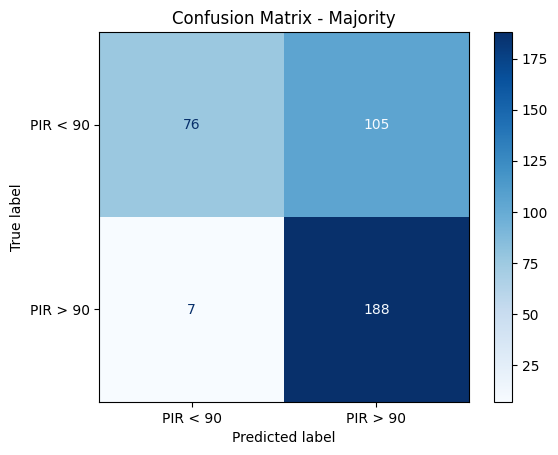


------------------------- SOFTMAX_MEAN NİHAİ ANALİZ -------------------------
              precision    recall  f1-score   support

    PIR < 90       0.84      0.81      0.82       181
    PIR > 90       0.83      0.86      0.84       195

    accuracy                           0.84       376
   macro avg       0.84      0.83      0.83       376
weighted avg       0.84      0.84      0.83       376



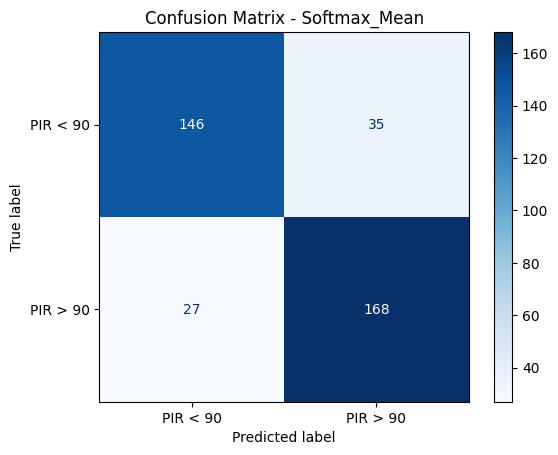


------------------------- WEIGHTED NİHAİ ANALİZ -------------------------
              precision    recall  f1-score   support

    PIR < 90       0.92      0.93      0.93       181
    PIR > 90       0.94      0.92      0.93       195

    accuracy                           0.93       376
   macro avg       0.93      0.93      0.93       376
weighted avg       0.93      0.93      0.93       376



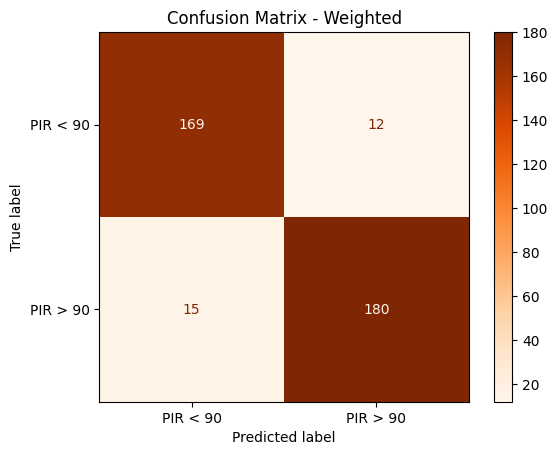


------------------------- STACKING NİHAİ ANALİZ -------------------------
              precision    recall  f1-score   support

    PIR < 90       0.87      0.86      0.87       181
    PIR > 90       0.87      0.88      0.88       195

    accuracy                           0.87       376
   macro avg       0.87      0.87      0.87       376
weighted avg       0.87      0.87      0.87       376



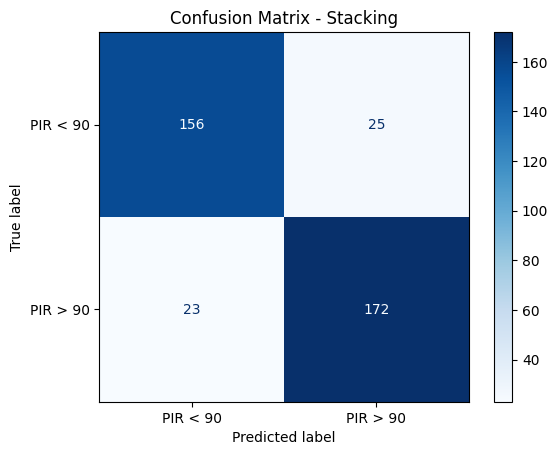

In [17]:
# 1. Hazırlık
methods = ["Majority", "Softmax_Mean", "Weighted", "Stacking"]
late_results = {m: {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []} for m in methods}

# Nihai raporlama için tahminleri toplama
all_preds = {m: {'true': [], 'pred': []} for m in methods}

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Late Fusion İşlemleri Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_s_tr, X_s_val = X_stats_raw[train_idx], X_stats_raw[val_idx]
    X_t_tr, X_t_val = X_text_features[train_idx], X_text_features[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_s_tr = scaler.fit_transform(X_s_tr)
    X_s_val = scaler.transform(X_s_val)

    # 2. Model 1: İstatistik Modeli
    model_stats = Sequential([Input(shape=(X_s_tr.shape[1],)), Dense(32, activation='relu'), Dense(1, activation='sigmoid')])
    model_stats.compile(optimizer='adam', loss='binary_crossentropy')
    model_stats.fit(X_s_tr, y_tr, epochs=30, batch_size=16, verbose=0)
    prob_stats = model_stats.predict(X_s_val, verbose=0).flatten()

    # 3. Model 2: Metin Modeli
    model_text = Sequential([Input(shape=(X_t_tr.shape[1],)), Dense(64, activation='relu'), Dense(1, activation='sigmoid')])
    model_text.compile(optimizer='adam', loss='binary_crossentropy')
    model_text.fit(X_t_tr, y_tr, epochs=30, batch_size=16, verbose=0)
    prob_text = model_text.predict(X_t_val, verbose=0).flatten()

    # --- FUSION HESAPLAMALARI ---
    p_soft = (prob_stats + prob_text) / 2
    p_weight = (prob_stats * 0.7) + (prob_text * 0.3)
    p_maj_val = (( (prob_stats > 0.5).astype(int) + (prob_text > 0.5).astype(int) ) >= 1).astype(int)

    # Stacking
    X_meta_tr = np.column_stack([model_stats.predict(X_s_tr, verbose=0), model_text.predict(X_t_tr, verbose=0)])
    X_meta_val = np.column_stack([prob_stats, prob_text])
    meta_model = LogisticRegression().fit(X_meta_tr, y_tr)
    p_stack_prob = meta_model.predict_proba(X_meta_val)[:, 1]
    p_stack_class = meta_model.predict(X_meta_val)

    probs_dict = {"Majority": p_maj_val, "Softmax_Mean": p_soft, "Weighted": p_weight, "Stacking": p_stack_prob}
    preds_dict = {"Majority": p_maj_val, "Softmax_Mean": (p_soft > 0.5).astype(int),
                  "Weighted": (p_weight > 0.5).astype(int), "Stacking": p_stack_class}

    # FOLD BAZLI TABLO BAŞLIĞI
    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)

    for m in methods:
        y_p = preds_dict[m]
        y_prob = probs_dict[m]
        tn, fp, fn, tp = confusion_matrix(y_val, y_p).ravel()

        # Metrik Hesaplama
        f1 = f1_score(y_val, y_p)
        acc = accuracy_score(y_val, y_p)
        auc = roc_auc_score(y_val, y_prob)

        # Listelere ekle
        late_results[m]['acc'].append(acc)
        late_results[m]['f1'].append(f1)
        late_results[m]['auc'].append(auc)
        late_results[m]['prec'].append(precision_score(y_val, y_p, zero_division=0))
        late_results[m]['rec'].append(recall_score(y_val, y_p))
        late_results[m]['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        late_results[m]['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

        all_preds[m]['true'].extend(y_val)
        all_preds[m]['pred'].extend(y_p)

        print(f"{m:15} | {f1:.4f} | {acc:.4f} | {auc:.4f}")

# --- RAPORLAMA ---
print("\n" + "="*85)
print(f"{'Method':15} | {'F1 (Mean±Std)':20} | {'Acc (Mean±Std)':20} | {'AUC (Mean±Std)':20}")
print("-" * 85)
for m in methods:
    print(f"{m:15} | {np.mean(late_results[m]['f1']):.4f}±{np.std(late_results[m]['f1']):.3f} | "
          f"{np.mean(late_results[m]['acc']):.4f}±{np.std(late_results[m]['acc']):.3f} | "
          f"{np.mean(late_results[m]['auc']):.4f}±{np.std(late_results[m]['auc']):.3f}")

# Detaylı Analiz
for m in methods:
    print(f"\n{'-'*25} {m.upper()} NİHAİ ANALİZ {'-'*25}")
    print(classification_report(all_preds[m]['true'], all_preds[m]['pred'], target_names=['PIR < 90', 'PIR > 90']))

    cm = confusion_matrix(all_preds[m]['true'], all_preds[m]['pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PIR < 90', 'PIR > 90'])
    disp.plot(cmap=plt.cm.Blues if m != "Weighted" else plt.cm.Oranges)
    plt.title(f"Confusion Matrix - {m}")
    plt.show()

### BiLSTM

BiLSTM Metin Modeli Testi Başlatılıyor (5-Fold CV)...

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Fold 1 tamamlandı -> Acc: 0.4868 | F1: 0.5714 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Fold 2 tamamlandı -> Acc: 0.4400 | F1: 0.3438 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
Fold 3 tamamlandı -> Acc: 0.6000 | F1: 0.6667 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Fold 4 tamamlandı -> Acc: 0.5733 | F1: 0.6735 | AUC: 0.8910
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Fold 5 tamamlandı -> Acc: 0.5067 | F1: 0.6022 | AUC: 0.8910

BiLSTM TEXT MODEL FINAL RESULTS (Mean ± Std)
ACC       : 0.5214 ± 0.0582
F1        : 0.5715 ± 0.1202
PREC      : 0.5212 ± 0.0510
REC       : 0.6564 ± 0.1964
SENS      : 0.6564 ± 0.1964
SPEC      : 0.3761 ± 0.1284
AUC       : 0.5181 ± 0.0687

BiLSTM GENEL CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    PIR < 90       0.50      0.38      0.43       181
    PIR > 90       0.53      0.66      0.59       195

    accu

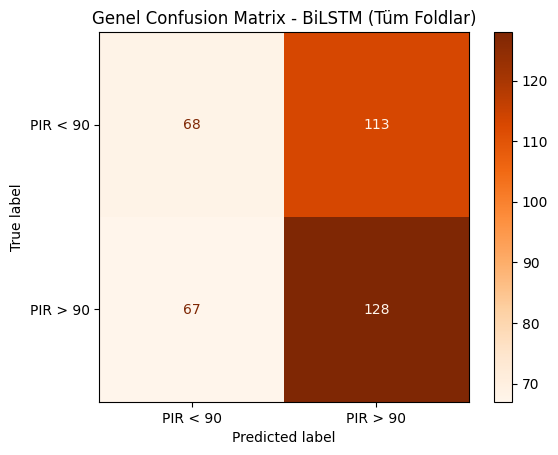

In [26]:
# 1. VERİ HAZIRLIĞI
texts = statistics['combined_news'].astype(str).tolist()
y = statistics['target'].values

max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_text_padded = pad_sequences(sequences, maxlen=max_len)

# 2. METRİK TAKİBİ VE TAHMİN HAVUZU
bilstm_metrics = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_bilstm = []
all_y_pred_bilstm = []

# 3. 5-FOLD CV DÖNGÜSÜ
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("BiLSTM Metin Modeli Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_text_padded, y), 1):
    X_tr, X_val = X_text_padded[train_idx], X_text_padded[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- MODEL MİMARİSİ ---
    model = Sequential([
        Input(shape=(max_len,)),
        Embedding(max_words, 128),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Eğitim
    model.fit(X_tr, y_tr, epochs=10, batch_size=32, verbose=0)

    # --- TAHMİN ---
    y_probs = model.predict(X_val)
    y_pred = (y_probs > 0.5).astype("int32")

    # Genel Raporlama İçin Sakla
    all_y_true_bilstm.extend(y_val)
    all_y_pred_bilstm.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    bilstm_metrics['acc'].append(acc)
    bilstm_metrics['f1'].append(f1)
    bilstm_metrics['prec'].append(precision_score(y_val, y_pred))
    bilstm_metrics['rec'].append(recall_score(y_val, y_pred))
    bilstm_metrics['sens'].append(tp / (tp + fn))
    bilstm_metrics['spec'].append(tn / (tn + fp))
    bilstm_metrics['auc'].append(auc_val)

    print(f"Fold {fold} tamamlandı -> Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


print("\n" + "="*45)
print("BiLSTM TEXT MODEL FINAL RESULTS (Mean ± Std)")
for metrik, degerler in bilstm_metrics.items():
    print(f"{metrik.upper():10}: {np.mean(degerler):.4f} ± {np.std(degerler):.4f}")
print("="*45)

# 1. Genel Classification Report
print("\nBiLSTM GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_bilstm, all_y_pred_bilstm, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_bilstm = confusion_matrix(all_y_true_bilstm, all_y_pred_bilstm)
disp_bilstm = ConfusionMatrixDisplay(confusion_matrix=cm_bilstm, display_labels=['PIR < 90', 'PIR > 90'])
disp_bilstm.plot(cmap=plt.cm.Oranges)
plt.title("Genel Confusion Matrix - BiLSTM (Tüm Foldlar)")
plt.show()

### DistilBERT

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/410 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

DistilBERT özellikleri çıkarılıyor...

DistilBERT 5-Fold Cross-Validation Başlatılıyor...

>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6792 | 0.5526 | 0.6590

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6600 | 0.5467 | 0.4694

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6538 | 0.5200 | 0.5666

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6275 | 0.4933 | 0.4163

>>> FOLD 5 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
DistilBERT      | 0.6471 | 0.5200 | 0.5050

DISTILBERT FINAL REPORT        | Mean ± Std
------------------------------------------------------------
ACC                          

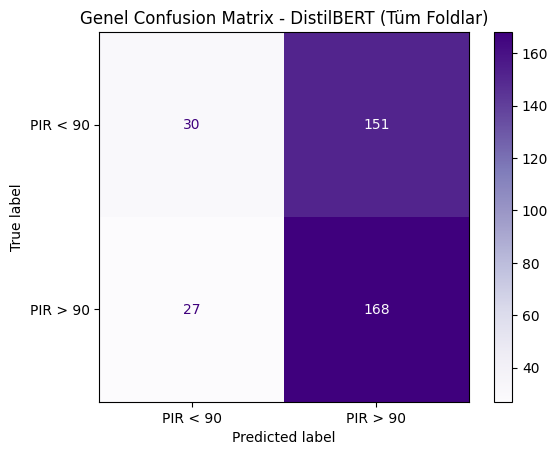

In [19]:
# 1. DistilBERT Modelini Yükle (dbmdz/distilbert-base-turkish-cased)
distil_model_name = "dbmdz/distilbert-base-turkish-cased"
distil_tokenizer = AutoTokenizer.from_pretrained(distil_model_name)
distil_model = AutoModel.from_pretrained(distil_model_name)

def get_distilbert_embeddings(text_list):
    inputs = distil_tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = distil_model(**inputs)
    # [CLS] token'ı (0. indeks) metnin anlamsal özetidir (768-D)
    return outputs.last_hidden_state[:, 0, :].numpy()

# 2. Öznitelik Çıkarımı
print("DistilBERT özellikleri çıkarılıyor...")
distil_text_features = []
for i in range(len(statistics)):
    text = str(statistics['combined_news'].iloc[i])
    emb = get_distilbert_embeddings([text])
    distil_text_features.append(emb[0])

X_distil_feat = np.array(distil_text_features)
y = statistics['target'].values

# 3. Metrik Takibi ve Tahmin Havuzu
dist_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_dist = []
all_y_pred_dist = []

# 4. Single-Modality Testi (5-Fold CV)
print("\nDistilBERT 5-Fold Cross-Validation Başlatılıyor...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_distil_feat, y), 1):
    X_tr, X_val = X_distil_feat[train_idx], X_distil_feat[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    # --- MODEL MİMARİSİ ---
    model = Sequential([
        Input(shape=(768,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_tr, y_tr, epochs=15, batch_size=16, verbose=0)

    # --- TAHMİN ---
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    all_y_true_dist.extend(y_val)
    all_y_pred_dist.extend(y_pred.flatten())

    # --- METRİKLERİN HESAPLANMASI ---
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    dist_results['acc'].append(acc)
    dist_results['f1'].append(f1)
    dist_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    dist_results['rec'].append(recall_score(y_val, y_pred))
    dist_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    dist_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    dist_results['auc'].append(auc_val)

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)
    print(f"{'DistilBERT':15} | {f1:.4f} | {acc:.4f} | {auc_val:.4f}")

# --- RAPORLAMA ---
print("\n" + "="*60)
print(f"{'DISTILBERT FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 60)
for m in dist_results:
    print(f"{m.upper():30} | {np.mean(dist_results[m]):.4f} ± {np.std(dist_results[m]):.3f}")
print("="*60)

# 1. Genel Classification Report
print("\nDISTILBERT GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_dist, all_y_pred_dist, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_dist = confusion_matrix(all_y_true_dist, all_y_pred_dist)
disp_dist = ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=['PIR < 90', 'PIR > 90'])
disp_dist.plot(cmap=plt.cm.Purples)
plt.title("Genel Confusion Matrix - DistilBERT (Tüm Foldlar)")
plt.show()

### TabTransformer

Tabular Transformer (Transformer 1) 5-Fold CV Başlatılıyor...


>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.8312 | 0.8289 | 0.9078

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.8861 | 0.8800 | 0.9380

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.9114 | 0.9067 | 0.9758

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.9250 | 0.9200 | 0.9679

>>> FOLD 5 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Tabular Trans.  | 0.9067 | 0.9067 | 0.9658

TABULAR TRANSFORMER FINAL REPORT | Mean ± Std
-------------------------------------------------------
ACC                            | 0.8885 ± 0.032
F1         

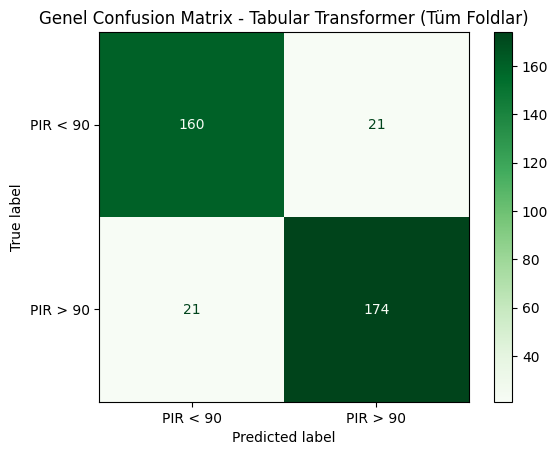

In [20]:
def create_tabular_transformer(input_dim):
    inputs = Input(shape=(input_dim,))

    # 1. Feature Projection (Embedding Uzayı)
    x = Dense(64, activation='relu')(inputs)
    x = Reshape((1, 64))(x) # Attention 3B Tensör (Batch, Sequence, Dim) bekler

    # 2. Transformer Bloğu (Self-Attention)
    # Sayısal özellikler arasındaki gizli ilişkileri öğrenir
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(attention_output + x) # Residual connection

    # 3. Classification Head
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrikleri ve tüm tahminleri tutmak için yapılar
tab_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_tab = []
all_y_pred_tab = []

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Tabular Transformer (Transformer 1) 5-Fold CV Başlatılıyor...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_tr_raw, X_val_raw = X_stats_raw[train_idx], X_stats_raw[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = create_tabular_transformer(X_tr.shape[1])
    model.fit(X_tr, y_tr, epochs=30, batch_size=16, verbose=0)

    # Tahmin (Olasılık ve Sınıf)
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    # Genel Raporlama İçin Sakla
    all_y_true_tab.extend(y_val)
    all_y_pred_tab.extend(y_pred.flatten())

    # Metrikleri hesapla
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    tab_results['acc'].append(acc)
    tab_results['f1'].append(f1)
    tab_results['auc'].append(auc_val)
    tab_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    tab_results['rec'].append(recall_score(y_val, y_pred))
    tab_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    tab_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)
    print(f"{'Tabular Trans.':15} | {f1:.4f} | {acc:.4f} | {auc_val:.4f}")


print("\n" + "="*55)
print(f"{'TABULAR TRANSFORMER FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in tab_results:
    print(f"{m.upper():30} | {np.mean(tab_results[m]):.4f} ± {np.std(tab_results[m]):.3f}")
print("="*55)

# 1. Genel Classification Report
print("\nTABULAR TRANSFORMER GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_tab, all_y_pred_tab, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_tab = confusion_matrix(all_y_true_tab, all_y_pred_tab)
disp_tab = ConfusionMatrixDisplay(confusion_matrix=cm_tab, display_labels=['PIR < 90', 'PIR > 90'])
disp_tab.plot(cmap=plt.cm.Greens)
plt.title("Genel Confusion Matrix - Tabular Transformer (Tüm Foldlar)")
plt.show()

### Informer

Informer Sayısal Model Testi Başlatılıyor (5-Fold CV)...


>>> FOLD 1 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.8462 | 0.8421 | 0.9120

>>> FOLD 2 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9000 | 0.8933 | 0.9494

>>> FOLD 3 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9250 | 0.9200 | 0.9850

>>> FOLD 4 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.9487 | 0.9467 | 0.9687

>>> FOLD 5 SONUÇLARI:
Method          | F1     | Acc    | AUC   
---------------------------------------------
Informer        | 0.8831 | 0.8800 | 0.9402

INFORMER FINAL REPORT          | Mean ± Std
-------------------------------------------------------
ACC                            | 0.8964 ± 0.036
F1                

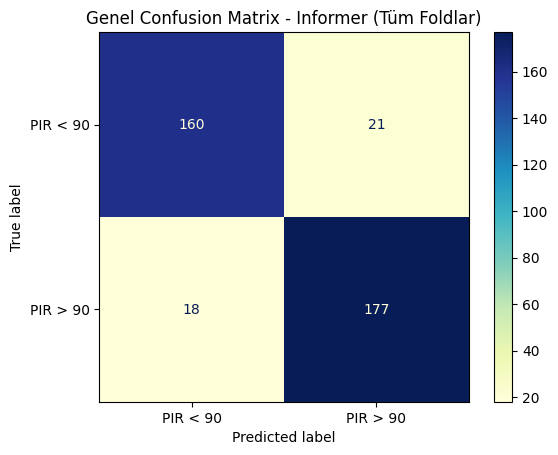

In [21]:
def create_informer_lite_model(input_dim):
    inputs = Input(shape=(input_dim,))

    # 1. Feature Projection
    x = Dense(64, activation='relu')(inputs)
    x = Reshape((1, 64))(x)

    # 2. Informer-style Attention Block (8 Headed Attention)
    # İstatistikler arası global ilişkileri yakalamak için
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = LayerNormalization()(attention_output + x)

    # Informer Distilling (Conv1D ile en önemli özellikleri süzme/damıtma)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
    x = Dropout(0.1)(x)

    # 3. Sınıflandırma Başlığı
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Metrik takibi ve tüm tahmin havuzu
inf_results = {'acc': [], 'f1': [], 'prec': [], 'rec': [], 'sens': [], 'spec': [], 'auc': []}
all_y_true_inf = []
all_y_pred_inf = []

X_stats_raw = df.drop(columns=["target","Performance Index Rating", "combined_news","Opposing Team", "Date","Year","Month","Day"]).values
y = df["target"].values

print("Informer Sayısal Model Testi Başlatılıyor (5-Fold CV)...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_stats_raw, y), 1):
    X_tr_raw, X_val_raw = X_stats_raw[train_idx], X_stats_raw[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr_raw)
    X_val = scaler.transform(X_val_raw)

    model = create_informer_lite_model(X_tr.shape[1])
    model.fit(X_tr, y_tr, epochs=25, batch_size=16, verbose=0)

    # Tahmin
    y_probs = model.predict(X_val, verbose=0)
    y_pred = (y_probs > 0.5).astype(int)

    # Genel raporlama için sakla
    all_y_true_inf.extend(y_val)
    all_y_pred_inf.extend(y_pred.flatten())

    # Metriklerin hesaplanması
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_val = roc_auc_score(y_val, y_probs)

    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

    inf_results['acc'].append(acc)
    inf_results['f1'].append(f1)
    inf_results['auc'].append(auc_val)
    inf_results['prec'].append(precision_score(y_val, y_pred, zero_division=0))
    inf_results['rec'].append(recall_score(y_val, y_pred))
    inf_results['sens'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    inf_results['spec'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    print(f"\n>>> FOLD {fold} SONUÇLARI:")
    print(f"{'Method':15} | {'F1':6} | {'Acc':6} | {'AUC':6}")
    print("-" * 45)
    print(f"{'Informer':15} | {f1:.4f} | {acc:.4f} | {auc_val:.4f}")


print("\n" + "="*55)
print(f"{'INFORMER FINAL REPORT':30} | {'Mean ± Std'}")
print("-" * 55)
for m in inf_results:
    print(f"{m.upper():30} | {np.mean(inf_results[m]):.4f} ± {np.std(inf_results[m]):.3f}")
print("="*55)

# 1. Genel Classification Report
print("\nINFORMER GENEL CLASSIFICATION REPORT:")
print(classification_report(all_y_true_inf, all_y_pred_inf, target_names=['PIR < 90', 'PIR > 90']))

# 2. Genel Confusion Matrix Çizimi
cm_inf = confusion_matrix(all_y_true_inf, all_y_pred_inf)
disp_inf = ConfusionMatrixDisplay(confusion_matrix=cm_inf, display_labels=['PIR < 90', 'PIR > 90'])
disp_inf.plot(cmap=plt.cm.YlGnBu)
plt.title("Genel Confusion Matrix - Informer (Tüm Foldlar)")
plt.show()